# Developing an AI application - PyTorch Image Classifier

Going forward, AI algorithms will be incorporated into more and more everyday applications. In this project, I trained an image classifier to recognize different species of flowers. Using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, I
* Load and preprocessed the image dataset
* Trained the image classifier on your dataset
* Used the trained classifier to predict image content

An example of what the images look like is below:

<img src='assets/Flowers.png' width=500px>


The goal of this project is to creant an application that can be trained on any set of labeled images. The network will be learn about flowers and end up as a command line application.

## Import Required Packages

In [68]:
import torch
import torchvision
from torchvision import models, transforms, datasets
from collections import OrderedDict
import json
from workspace_utils import active_session
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Load the data

Below I used `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). Then I split the dataset into three parts, training, validation, and testing. For the training, I applied transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I also needed to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this I don't want any scaling or rotation transformations, but still needed to resize then crop the images to the appropriate size.

The pre-trained networks I used were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I normalized the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [12]:
# Defining transforms for the training, validation, and testing sets
data_transforms = {}
image_datasets = {}
data_transforms['train'] = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

data_transforms['valid_test'] = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
image_datasets['train'] = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
image_datasets['valid'] = datasets.ImageFolder(valid_dir, transform=data_transforms['valid_test'])
image_datasets['test'] = datasets.ImageFolder(test_dir, transform=data_transforms['valid_test'])

# Using the image datasets and the transforms, define the dataloaders
# num_workers = 4 removed because of Runtime Bus Error
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 64, shuffle = True)
              for x in ['train', 'valid', 'test']}

### Label mapping

I then loaded in a mapping from category label to category name from `cat_to_name.json`. This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [13]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. Next, I:
* Loaded a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Defined a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Trained the classifier layers using backpropagation using the pre-trained network to get the features
* Tracked the loss and accuracy on the validation set to determine the best hyperparameters

When training I only update the weights of the feed-forward network.

In [14]:
# Building and training the network

# Allows for automation of building linear, relu, dropout alternating layers ending in a log softmax
def classifier_builder(input_size, hidden_sizes, output_size, dropout):
    sizes = [input_size] + hidden_sizes + [output_size]
    layer_list = []
    
    for i in range(1, len(sizes)):
        layer_list.append(('fc' + str(i), torch.nn.Linear(sizes[i-i], sizes[i])))
        if  i < len(sizes) - 1:
            layer_list.append(('relu' + str(i), torch.nn.ReLU()))
            layer_list.append(('drop' + str(i), torch.nn.Dropout(dropout)))
            
    layer_list.append(('output', torch.nn.LogSoftmax(dim=1)))
    classifier = torch.nn.Sequential(OrderedDict(layer_list))
    
    return classifier

In [15]:
# Allows for easy model testing
def model_creator(arch):
    model = eval('models.' + arch + '(pretrained = True)')
    
    # Freeze parameters so they are not backprop through them
    for param in model.parameters():
        param.requires_grad = False
        
    return model

In [16]:
## NOTE: This block will not run without a GPU
input_size = 25088 # Because 224 pixels...
hidden_sizes = []
output_size = 102 # Because 102 flower categories
dropout = 0

arch = 'vgg16' # The model architecture is PyTorch's VGG16
# Using Cuda for GPU usage below
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

model = model_creator(arch)
model.classifier = classifier_builder(input_size, hidden_sizes, output_size, dropout)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [17]:
def validate(model, valid_dataloader, criterion, device):
    model.to(device)
    
    valid_loss = 0
    accuracy = 0
    for i, (inputs, labels) in enumerate(valid_dataloader):
        
        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        valid_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return valid_loss, accuracy

In [18]:
def training(epochs, print_every, model, train_dataloader, valid_dataloader,
             optimizer, criterion, device):
        model.to(device)
        steps = 0
        
        for e in range(epochs):
            loss_so_far = 0 # the variable will be the loss for each batch
            model.train()
            for i, (inputs, labels) in enumerate(train_dataloader):
                steps += 1
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Zeros the gradients so that next iteration
                # has zero gradients/"starts fresh"
                optimizer.zero_grad()
                
                outputs = model.forward(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                # Calculate the total loss for 1 epoch of training
                loss_so_far += loss.item()
                
                if steps % print_every == 0:
                    model.eval()
                    
                    with torch.no_grad():
                        valid_loss, accuracy = validate(model, valid_dataloader,
                                                       criterion, device)
                        
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                         "Training Loss: {:.3f}.. ".format(loss_so_far/print_every),
                         "Validation Loss: {:.3f}..".format(valid_loss/len(valid_dataloader)),
                        "Validation Accuracy: {:.3f}..".format(accuracy/len(valid_dataloader)))
                    
                    loss_so_far = 0
                    
                    model.train()

In [19]:
with active_session(): 
    epochs = 8 # number of forward-backward pass pairs
    print_every = 40 # frequency to print data
    learning_rate = 0.01

    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)

    training(epochs, print_every, model, dataloaders['train'],
             dataloaders['valid'], optimizer, criterion, device)

Epoch: 1/8..  Training Loss: 30.434..  Validation Loss: 9.541.. Validation Accuracy: 0.645..
Epoch: 1/8..  Training Loss: 15.132..  Validation Loss: 9.811.. Validation Accuracy: 0.700..
Epoch: 2/8..  Training Loss: 5.040..  Validation Loss: 7.415.. Validation Accuracy: 0.763..
Epoch: 2/8..  Training Loss: 11.376..  Validation Loss: 7.121.. Validation Accuracy: 0.792..
Epoch: 2/8..  Training Loss: 11.657..  Validation Loss: 7.004.. Validation Accuracy: 0.815..
Epoch: 3/8..  Training Loss: 9.299..  Validation Loss: 7.948.. Validation Accuracy: 0.792..
Epoch: 3/8..  Training Loss: 11.246..  Validation Loss: 6.508.. Validation Accuracy: 0.830..
Epoch: 4/8..  Training Loss: 3.143..  Validation Loss: 7.017.. Validation Accuracy: 0.832..
Epoch: 4/8..  Training Loss: 10.565..  Validation Loss: 7.233.. Validation Accuracy: 0.827..
Epoch: 4/8..  Training Loss: 11.930..  Validation Loss: 7.720.. Validation Accuracy: 0.816..
Epoch: 5/8..  Training Loss: 7.164..  Validation Loss: 7.277.. Validation

## Testing the network

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images.

In [20]:
# Validation on the test set
def test_accuracy(model, test_dataloader):
    correct = 0
    total = 0
    
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print('Accuracy of the network on the 10,000 test images: %d %%'
         % (100 * correct / total))

In [21]:
test_accuracy(model, dataloaders['test'])

Accuracy of the network on the 10,000 test images: 86 %


## Save the checkpoint

Now that the network is trained, I saved the model so that I could load it later for making predictions. I also saved other things such as the mapping of classes to indices which I got from one of the image datasets: `image_datasets['train'].class_to_idx`. I attached this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

To load the model and keep training, I saved the number of epochs as well as the optimizer state, `optimizer.state_dict`. I also saved the trained model so that I could use it in the next part of the project.

In [52]:
# Save the checkpoint
def save_checkpoint(input_size, output_size, hidden_sizes,
                   dropout, class_to_idx, arch, epochs,
                   optimizer, learning_rate):
    checkpoint = {'input_size': input_size,
                  'hidden_sizes': hidden_sizes,
                  'output_size': output_size,
                  'dropout': dropout,
                  'state_dict': model.classifier.state_dict(),
                  'mapping': class_to_idx,
                  'arch': arch,
                  'epochs': epochs,
                  'learning_rate': learning_rate,
                  'optimizer': optimizer.state_dict()
                  }
    torch.save(checkpoint, 'checkpoint.pth')

In [28]:
mapping = image_datasets['train'].class_to_idx
save_checkpoint(input_size, output_size, hidden_sizes, dropout, mapping,
                arch, epochs, optimizer, learning_rate)

## Loading the checkpoint

At this point I wrote a function that can load a checkpoint and rebuild the model. That way I can come back to this project and keep working on it without having to retrain the network.

In [29]:
# Function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = model_creator(checkpoint['arch'])
    classifier = classifier_builder(checkpoint['input_size'],
                    checkpoint['hidden_sizes'],
                    checkpoint['output_size'],
                    checkpoint['dropout'])
    classifier.load_state_dict(checkpoint['state_dict'])
    
    model.classifier = classifier
    optimizer = torch.optim.Adam(model.classifier.parameters(), 
                                 lr = checkpoint['learning_rate'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epochs']
    
    return model, optimizer, start_epoch

In [58]:
model, optimizer, start_epoch = load_checkpoint('checkpoint.pth')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Inference for classification

Now I've writen a function to use a trained network for inference. That is, I've passed an image into the network and predicted the class of the flower in the image. Next, I will handle processing the input image and then write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities.

## Image Preprocessing

I used `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, I resized the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then I needed to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1 so I needed to convert the values. It's easiest with a Numpy array, which I got from the PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. I subtracted the means from each color channel, then divide by the standard deviation to normalize the images.

Finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array so I reordered dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html).

In [59]:
# Function to Process a PIL image for use in a PyTorch model
def process_image(image):
    image = Image.open(image_path)
    
    # Scales/Resize
    width, height = image.size
    if width < height:
        new_width = 256
        new_height = int(height * float(new_width) / width)
    else:
        new_height = 256
        new_width = int(width * float(new_height) / height)
        
    image = image.resize((new_width, new_height))
    
    # Crop
    left = (new_width - 224) / 2
    right = new_width - (new_width - 224) / 2
    upper = (new_height - 224) / 2
    lower = new_height - (new_height - 224) / 2
    image = image.crop((left, upper, right, lower))
    
    # Normalize
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    np_image = np.array(image) / 255.0
    np_image = (np_image - means) / stds
    
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

To check my work, the function below converts a PyTorch tensor and displays it in the notebook. If my `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [60]:
# Scales, crops, and normalizes a PIL image for a PyTorch model, returns an Numpy array
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.set_title(title)
    
    return ax

## Class Prediction

After the images are in the correct format, I wrote a function to making predictions with the model. I set it to predict the top 5 most probable classes and to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor, I used [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. Then I converted from these indices to the actual class labels using `class_to_idx`, which I called mapping. 

In [61]:
#  Predicts the class from an image file using a trained deep learning model
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    model.to(device)
    
    # Prediction
    processed_image = process_image(image_path)
    image_tensor = torch.from_numpy(np.expand_dims(processed_image, axis = 0)).float()
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        
    probs, labels = output.topk(topk)
    probs = np.array(probs.exp().data)[0]
    labels = np.array(labels)[0]
    
    return probs, labels

## Sanity Checking

Now that I used a trained model for predictions, I checked to make sure it maked sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. I used `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

I also converted from the class integer encoding to actual flower names with the `cat_to_name.json` file and showed a PyTorch tensor as an image using the `imshow` function.

In [70]:
# Display an image along with the top 5 classes
def predict_display(image_path, model):
    probs, labels = predict(image_path, model)
    
    processed_image = process_image(image_path)
    label_map = {v: k for k, v in mapping.items()}
    classes = [cat_to_name[label_map[i]] for i in labels]
    
    title = cat_to_name[image_path.split('/')[-2]]
    
    f, (ax1, ax2) = plt.subplots(2, 1, figsize = (6,6))
    plt.tight_layout()
    
    imshow(processed_image, ax=ax1, title=title)
    
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    class_ticks = np.arange(len(classes))
    ax2.barh(class_ticks, probs)
    ax2.invert_yaxis()
    ax2.set_yticks(class_ticks)
    ax2.set_yticklabels(classes)

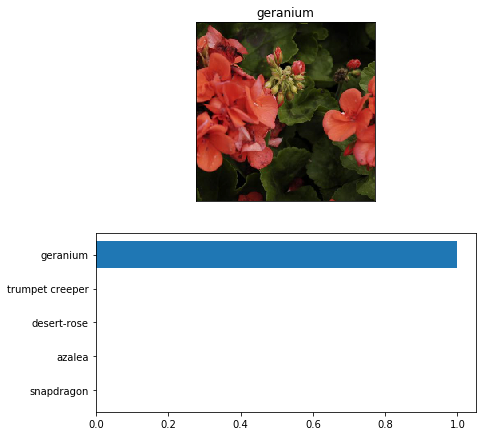

In [71]:
image_path = train_dir + '/58/image_02714.jpg'

predict_display(image_path, model)